<a href="https://colab.research.google.com/github/Markfesenk0/CycleGAN-colorization/blob/main/CycleGAN_image_colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import cv2
from skimage.color import rgb2lab, rgb2gray, lab2rgb
from skimage.io import imread, imshow
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import torchvision
from PIL import Image, ImageCms
from torchsummary import summary
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.transforms import InterpolationMode
import torch
import torch.nn as nn
import torch.optim as optim

import sys
import tqdm
import os
import shutil

data_path = 'small_test_256'

# dataset of 328K images
if data_path == 'test_256' and not os.path.isfile('test_256.tar'):
    !wget 'http://data.csail.mit.edu/places/places365/test_256.tar'
    shutil.unpack_archive("test_256.tar", "/content/data/")

# dataset of 20K images
elif data_path == 'small_test_256' and not os.path.isfile('small_test_256.zip'):
    !gdown --id '1_u1S2C6zuBgeT__QukSUP41sjs8uOg_M'
    shutil.unpack_archive("small_test_256.zip", "/content/data/")

# a, b datasets of 1.2K each
elif data_path == 'small_1200_a_b' and not os.path.isfile('small_1200_a_b.zip'):
    !gdown --id '1pAAqA43c4dquxNr-QGaO5yQ8uzghMNGO'
    shutil.unpack_archive("small_1200_a_b.zip", "/content/data/")
    data_path = 'a'

In [ ]:
ROOT_PATH = "/content/data/" + data_path
CHECKPOINT_PATH = "/content/checkpoint.pth"
IM_SIZE = (256, 256)
# lab values (slow) : ((0.4684, 0.3875, 0.3123), (0.2328, 0.3646, 0.3273))
# lab values (fast) : ((0.4681, 0.5076, 0.5248), (0.2331, 0.0273, 0.0455))
# rgb values : ((0.4586, 0.4420, 0.4084), (0.2336, 0.2308, 0.2403))
STATS = ((46.7841,  1.4593,  5.8154), (23.2887,  7.1023, 11.7732))
BATCH_SIZE = 32
NUM_WORKERS = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Resize all images to 256*256 and normalize them to mean = 0 and standard-deviation = 1 based on statistics collected from the training set
default_transform = transforms.Compose([
    # transforms.Resize(IM_SIZE),
    # transforms.ToTensor(),
    transforms.Normalize(*STATS)
])

# Find normalizing parameters
def find_mean_std(loader):
    mean = 0.
    std = 0.
    with tqdm.tqdm(total=(len(loader)), file=sys.stdout) as pbar:
      for images in loader:
          # print(images.shape)
          batch_samples = images.size(0)  # batch size (the last batch can have smaller size!)
          images = images.view(batch_samples, images.size(1), -1)
          mean += images.mean(2).sum(0)
          std += images.std(2).sum(0)
          pbar.update(); 

    mean /= len(loader.dataset)
    std /= len(loader.dataset)
    print(mean, std)

# custom dataset for Places365
class Places365Dataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.root_path = ROOT_PATH

    def __len__(self):
        return len(os.listdir(self.root_path))

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.to_list()
        ending = '00000000' + str(index + 1)
        path_ending = 'Places365_test_' + ending[-8:] + '.jpg'

        im_rgb = Image.open(f'{self.root_path}/{path_ending}').convert("RGB")
        im_rgb = im_rgb.resize(IM_SIZE)
        im_rgb = np.array(im_rgb)
        im_lab = rgb2lab(im_rgb).astype("float32") # Converting RGB to L*a*b
        im_lab = transforms.ToTensor()(im_lab)
        l = im_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = im_lab[[1, 2], ...] / 110. # Between -1 and 1

        # # # # MAYBE GOOD
        # im_rgb = Image.open(f'{self.root_path}/{path_ending}').convert("RGB")
        # im_rgb = im_rgb.resize(IM_SIZE)
        # im_lab = rgb2lab(im_rgb)
        # # print_image_summary(im_lab, ['L', 'A', 'B'])
        # im_lab = transforms.ToTensor()(im_lab)
        # if self.transform:
        #     im_lab = self.transform(im_lab)
        # L = im_lab[[0], ...]
        # ab = im_lab[[1, 2], ...]

        return l, ab

# load dataset
def load_dataset():
    train_set = Places365Dataset(transform = default_transform)

    idxs = list(range(len(train_set)))
    np.random.shuffle(idxs)
    train_sample = torch.utils.data.sampler.SubsetRandomSampler(idxs)
    train_loader = torch.utils.data.DataLoader(train_set, sampler=train_sample, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

    return train_loader

# Denormalize images
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

# Shows a batch from the provided dataloader
def show_batch(dl):
    for l, ab in dl:
        l = (l + 1.0) * 50.0 # Between -1 and 1
        ab = ab * 110.0
        images = torch.cat((l, ab), 1)
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([])
        ax.set_yticks([])
        # denorm_images = denormalize(images, *STATS)
        denorm_images = images
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0, 1))
        break
    plt.show()
    return torch.reshape(images[0][0], (1, 256, 256)), images[0][-2:]

# Print image summary
def print_image_summary(image, labels):
    
    print('--------------')
    print('Image Details:')
    print('--------------')
    print(f'Image dimensions: {image.shape}')
    print('Channels:')
    
    if len(labels) == 1:
        image = image[..., np.newaxis]
        
    for i, lab in enumerate(labels):
        min_val = np.min(image[:,:,i])
        max_val = np.max(image[:,:,i])
        print(f'{lab} : min={min_val:.4f}, max={max_val:.4f}')

def my_lab2rgb(L, AB, denormalize = True):
        """Convert an Lab tensor image to a RGB numpy output
        Parameters:
            L  (1-channel tensor array): L channel images (range: [-1, 1], torch tensor array)
            AB (2-channel tensor array):  ab channel images (range: [-1, 1], torch tensor array)
        Returns:
            rgb (RGB numpy image): rgb output images  (range: [0, 255], numpy array)
        """
        AB2 = AB
        L2 = L
        if denormalize is True:
            AB2 = AB * 110.0
            L2 = (L + 1.0) * 50.0
        Lab = torch.cat((L2, AB2), dim=0)
        # Lab = Lab[0].data.cpu().float().numpy()
        Lab = Lab.data.cpu().float().numpy()
        Lab = np.transpose(Lab.astype(np.float64), (1, 2, 0))
        rgb = lab2rgb(Lab)
        return rgb

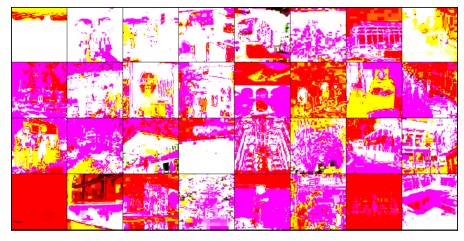

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


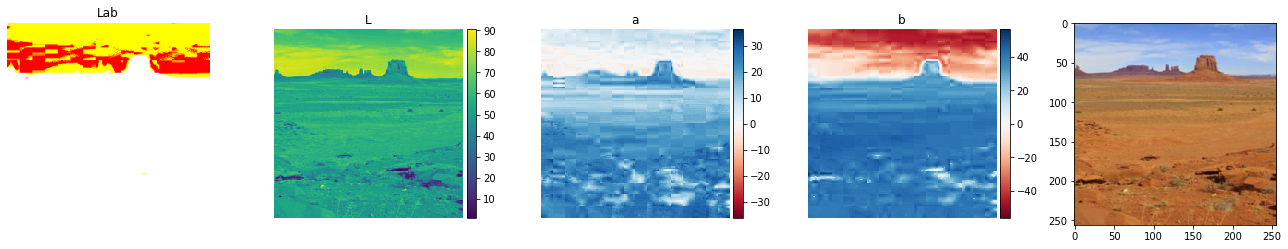

In [ ]:
# DEBUGGING: SOME VISUALIZATION
data_loader = load_dataset()
l, ab = show_batch(data_loader)
image_lab = torch.cat((l, ab), dim=0)
image_lab = image_lab.to('cpu').numpy()
image_lab = np.moveaxis(image_lab, 0, -1)
image_lab[0] = np.abs(image_lab[0])
im_rgb = my_lab2rgb(l, ab, denormalize = False)

# image_lab_scaled = (image_lab + [0, 128, 128]) / [100, 255, 255]
fig, ax = plt.subplots(1, 5, figsize = (18, 30))
ax[4].imshow(im_rgb)
ax[0].imshow(image_lab) 
ax[0].axis('off')
ax[0].set_title('Lab')
for i, col in enumerate(['L', 'a', 'b'], 1):
    imshow(image_lab[:, :, i-1], ax=ax[i])
    ax[i].axis('off')
    ax[i].set_title(col)
fig.show()

torch.Size([32, 3, 256, 256])


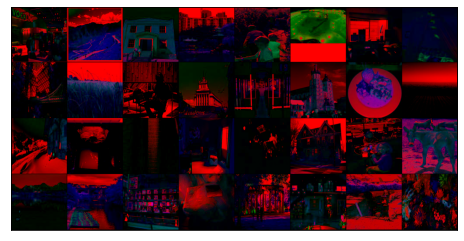

tensor([[[ 9.7389e-01,  7.0995e-01,  7.9677e-01,  ...,  6.5227e-01,
           4.0395e-01,  8.7201e-01],
         [ 6.1730e-01,  2.2299e-01,  2.7453e-01,  ..., -9.2324e-01,
          -8.9388e-01,  1.8488e-01],
         [ 7.1036e-01,  2.6219e-01,  2.7809e-01,  ..., -9.9921e-01,
          -9.7727e-01,  2.8828e-01],
         ...,
         [ 7.1063e-01,  2.5487e-01,  2.3863e-01,  ..., -1.0000e+00,
          -9.8355e-01,  3.3990e-01],
         [ 5.4115e-01,  1.5905e-01,  2.0808e-01,  ..., -8.9873e-01,
          -8.5505e-01,  1.5728e-01],
         [ 9.3924e-01,  6.8557e-01,  8.2448e-01,  ...,  6.1208e-01,
           4.4411e-01,  9.0290e-01]],

        [[-5.6909e-02, -4.7544e-02,  1.3915e-02,  ...,  1.1443e-02,
           1.1850e-02,  1.1135e-02],
         [-8.8223e-02, -5.4103e-02,  3.3685e-03,  ...,  1.1300e-02,
           1.3539e-02,  1.2278e-02],
         [-8.9229e-02, -5.3324e-02, -7.7872e-03,  ...,  2.5281e-03,
           2.5274e-03,  3.4910e-03],
         ...,
         [-2.3932e-02, -2

In [ ]:
data_loader = load_dataset()
show_batch(data_loader)
# find_mean_std(data_loader)